# Preliminary analysis of the budget-revenue data
## Exploratory data analysis

In [16]:
import json
from pathlib import Path
data_path = Path("tmdb_resources")
tmdb_id2detail = { k:json.loads(v) for k,v in json.load(open(data_path / 'tmdb_id2detail.json','r')).items() }
tmdb_id2credit = { k:json.loads(v) for k,v in json.load(open(data_path / 'tmdb_id2credit.json','r')).items() }

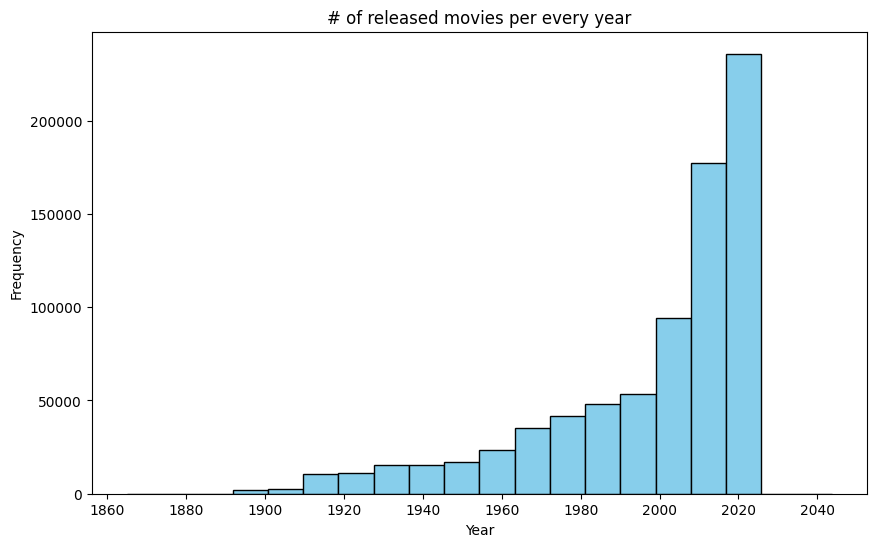

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

dates = pd.to_datetime([x['release_date'] for x in tmdb_id2detail.values()])

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('# of released movies per every year')
plt.show()

Each year, the number of movies grew exponentially. This trend reminds us to be very careful when analyzing data across years. ex. Simpson's paradox.

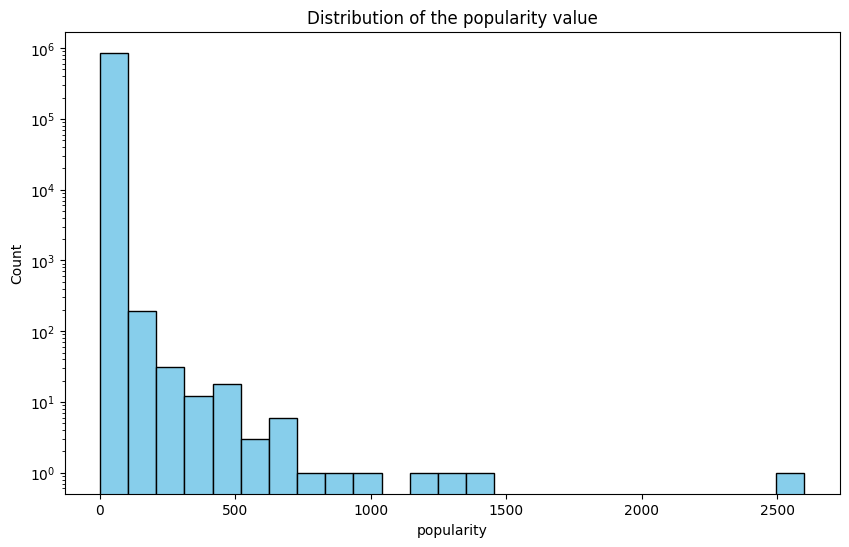

In [27]:
dates = [x['popularity'] for x in tmdb_id2detail.values()]

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=25, color='skyblue', edgecolor='black')
plt.xlabel('popularity')
plt.yscale('log')
plt.ylabel('Count')
plt.title('Distribution of the popularity value')
plt.show()

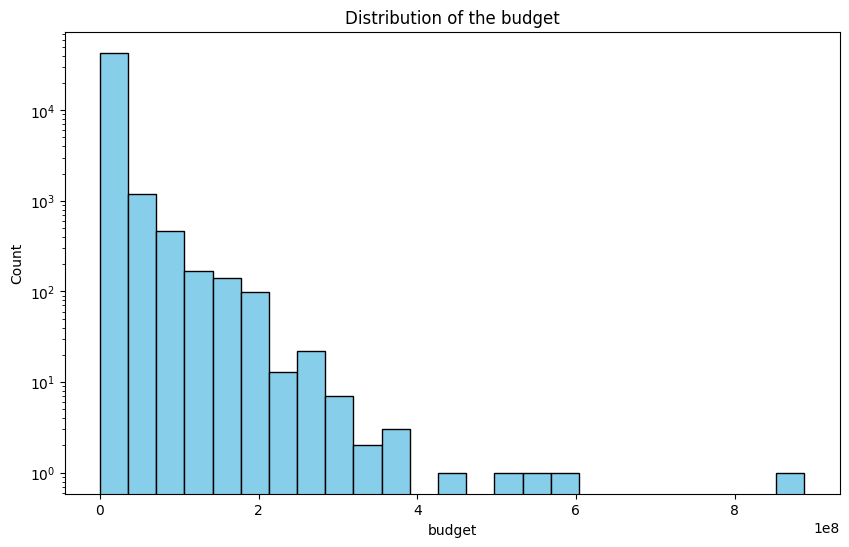

In [65]:
dates = [x['budget'] for x in tmdb_id2detail.values() if x['budget'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=25, color='skyblue', edgecolor='black')
plt.xlabel('budget')
plt.yscale('log')
plt.ylabel('Count')
plt.title('Distribution of the budget')
plt.show()

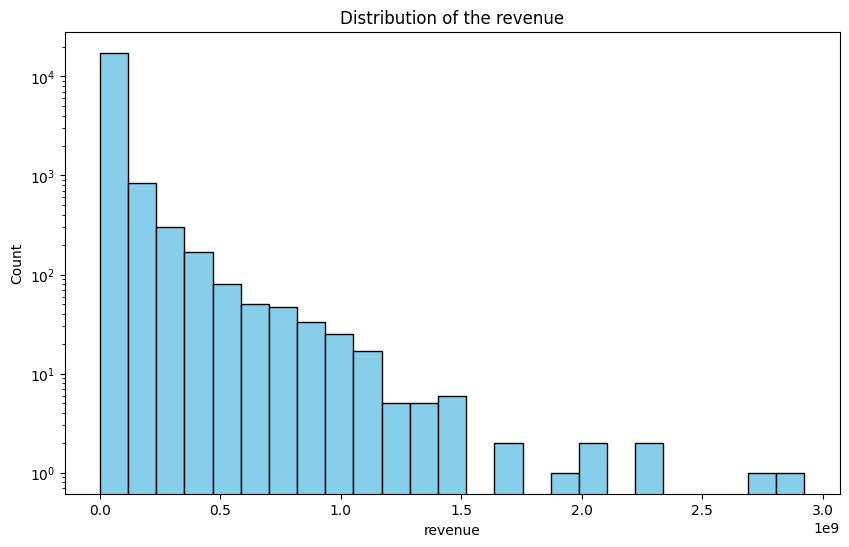

In [29]:
dates = [x['revenue'] for x in tmdb_id2detail.values() if x['revenue'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=25, color='skyblue', edgecolor='black')
plt.xlabel('revenue')
plt.yscale('log')
plt.ylabel('Count')
plt.title('Distribution of the revenue')
plt.show()

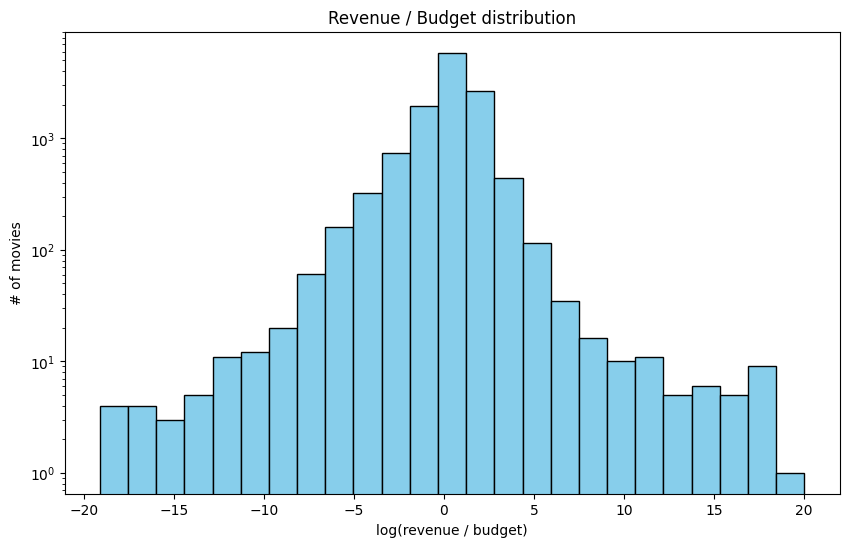

In [200]:
ratios = [math.log(x['revenue'] / x['budget']) for x in tmdb_id2detail.values() if x['revenue'] > 0 and x['budget'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(ratios, bins=25, color='skyblue', edgecolor='black')
plt.xlabel('log(revenue / budget)')
plt.yscale('log')
plt.ylabel('# of movies')
plt.title('Revenue / Budget distribution')
plt.show()

In [201]:
from scipy import stats
statistic, p_value = stats.normaltest(ratios)
print(statistic, p_value)
print(np.mean(ratios), np.std(ratios))

2778.555734602414 0.0
0.28286353973791983 2.192743877510451


The logarithm of the ratio of Revenue divided by budget looks like it follows a normal distribution. On average, the movie's revenue is 33% (e ^ 0.283 = 1.33) higher than the budget. According to the IMDB, the typical break-even point(BEP) is around 2.5x the budget of the movie.

In [203]:
len([ r for r in ratios if r < math.log(2.5)]) / len(ratios)

0.638343877632738

Based on the assumption of that typical BEP is 2.5, 63.8% of the entire movies failed to make a profit. To see if this interesting data varies by movie budget, we performed an additional boxplot analysis. 

In [209]:
from collections import defaultdict

budgets = [x['budget'] for x in tmdb_id2detail.values() if x['revenue'] > 0 and x['budget'] > 0]

budgets_with_ratios = [(x,y) for x,y in zip(budgets, ratios)]
budgets_with_ratios = sorted(budgets_with_ratios, key=lambda x: x[0])


bin_num = 10
bin_size = len(budgets_with_ratios) / bin_num

ratios_per_budget_interval = [[] for _ in range(bin_num)]
labels = [[max(budgets),min(budgets)] for _ in range(bin_num)]

for i, (budget, ratios) in enumerate(budgets_with_ratios):
    group = math.floor(i / bin_size)
    ratios_per_budget_interval[group].append(ratios)
    labels[group][0] = min(labels[group][0], budget)
    labels[group][1] = max(labels[group][1], budget)

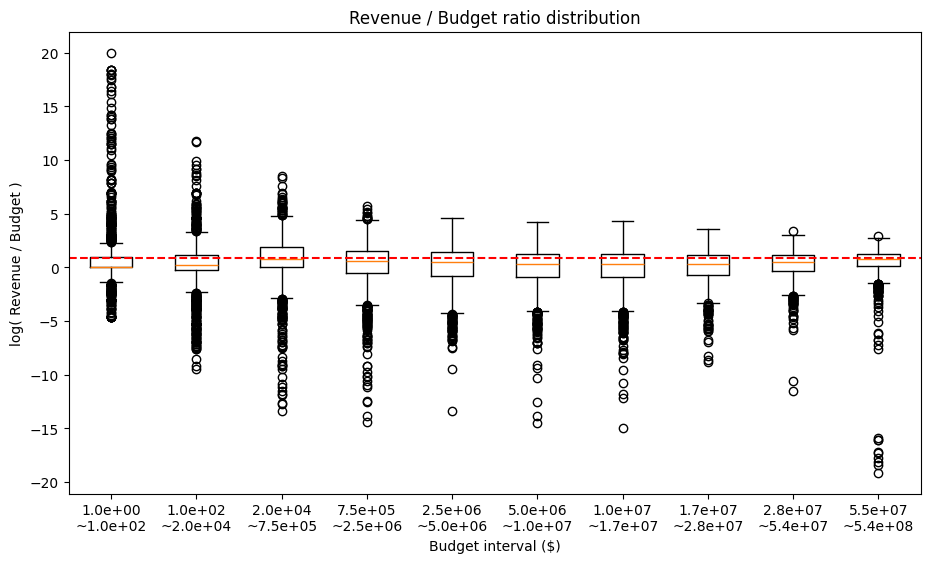

In [227]:
plt.figure(figsize=(11, 6))
label_str = [f"{min_v:.1e}\n~{max_v:.1e}" for min_v, max_v in labels]
plt.boxplot(ratios_per_budget_interval, labels = label_str)
plt.xlabel('Budget interval ($)')
plt.ylabel('log( Revenue / Budget )')

plt.axhline(y=math.log(2.5), color='r', linestyle='--', label='y=0')
plt.title('Revenue / Budget ratio distribution')
plt.show()

When the investment budget was divided into 10 sections with the same amount of data in each section, no noticeable trends could be identified through simple visualization.

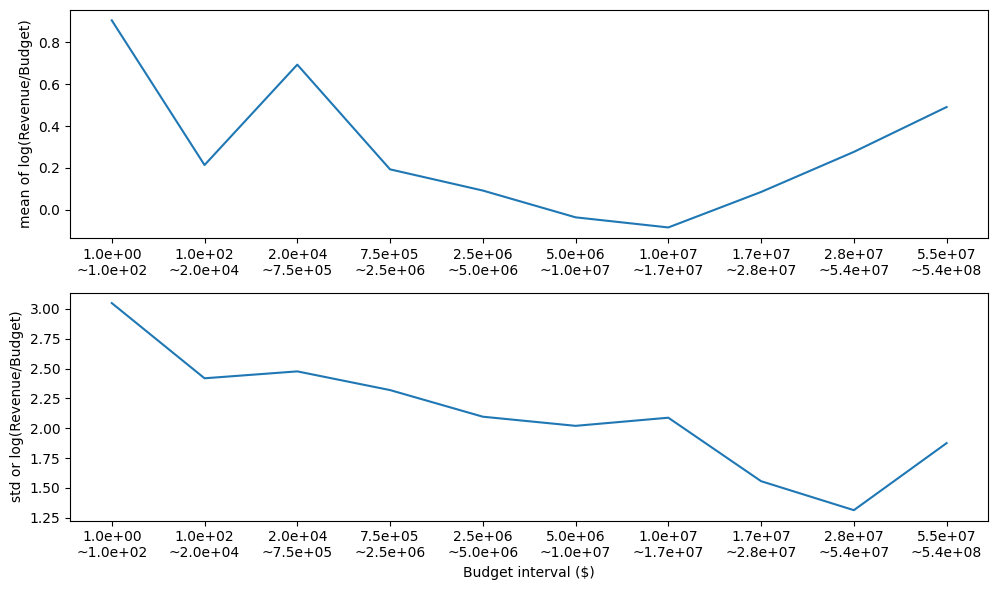

In [261]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(label_str, [np.mean(x) for x in ratios_per_budget_interval])
plt.ylabel('mean of log(Revenue/Budget)')

plt.subplot(2, 1, 2)
plt.plot(label_str, [np.std(x) for x in ratios_per_budget_interval])
plt.ylabel('std or log(Revenue/Budget)')
plt.xlabel('Budget interval ($)')

plt.tight_layout()
plt.show()

Looking at the graph showing the average and standard deviation, as the production cost of a movie increases, the standard deviation of the success rate decreases and becomes stable, but there is a section in the middle where the average success rate decreases significantly.

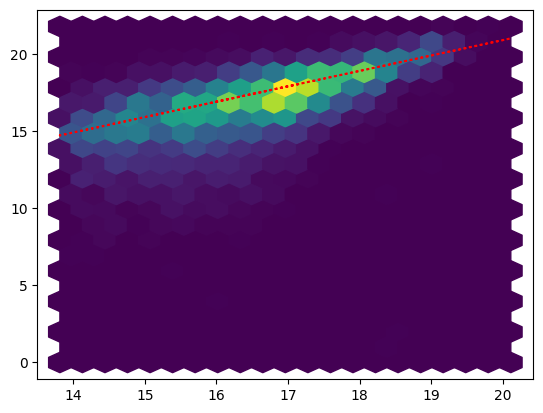

In [207]:
budgets = [math.log(x['budget']) for x in tmdb_id2detail.values() if x['revenue'] > 0 and x['budget'] > 1000000]
revenues = [math.log(x['revenue']) for x in tmdb_id2detail.values() if x['revenue'] > 0 and x['budget'] > 1000000]
plt.hexbin(budgets, revenues, gridsize=20)
plt.plot(budgets, [ x + math.log(2.5) for x in budgets], label='y=x', color='red', linestyle=':')

It is difficult to derive meaningful intuition also in hexbinplot. Red-dotted line is BEP.

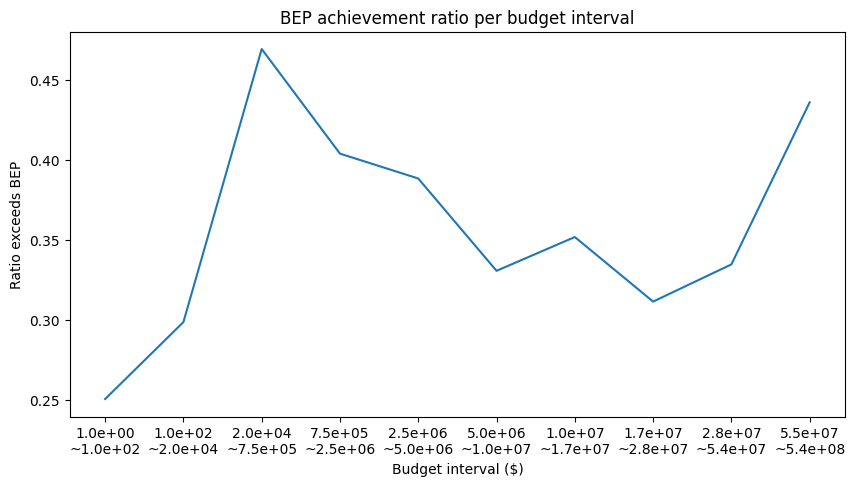

In [224]:
bep_over_ratios = []

for ratios in ratios_per_budget_interval:
    bep_over_ratios.append(len([r for r in ratios if r > math.log(2.5)]) / len(ratios))

plt.figure(figsize=(10, 5))
plt.plot(label_str, bep_over_ratios)
plt.xlabel('Budget interval ($)')
plt.ylabel('Ratio exceeds BEP')
plt.title('BEP achievement ratio per budget interval')
plt.show()

When analyzing the proportion of movies that generate a profit in each budget segment, we observe a bimodal distribution. Based on this, we can establish a criterion to categorize films into low-budget and high-budget groups. This categorization aims to minimize bias due to differences in success rates between the groups. It is expected that this will help identify a critical point for classification. This approach will be instrumental in addressing our research question, 'What is better for an actor's career: a lead role in a less-known/lower-budget movie or a secondary role in a successful/higher-budget movie?' This classification will provide a basis for our analysis.

In [270]:
min_diff = -1
min_idx = -1

for i in range(len(budgets_with_ratios)):
    if i == 0:
        continue
    lower_budget_group = [ x[1] for x in budgets_with_ratios[:i] ] 
    higher_budget_group = [ x[1] for x in budgets_with_ratios[i:] ]
    lower_success_rate = len([r for r in lower_budget_group if r > math.log(2.5)]) / len(lower_budget_group)
    higher_success_rate = len([r for r in higher_budget_group if r > math.log(2.5)]) / len(higher_budget_group)
    diff = abs(higher_success_rate - lower_success_rate)
    if min_diff == -1 or diff < min_diff:
        min_diff = diff
        min_idx = i

In [275]:
min_diff, budgets_with_ratios[min_idx]

(4.998745552875494e-06, (9500000, 0.6390799592896695))

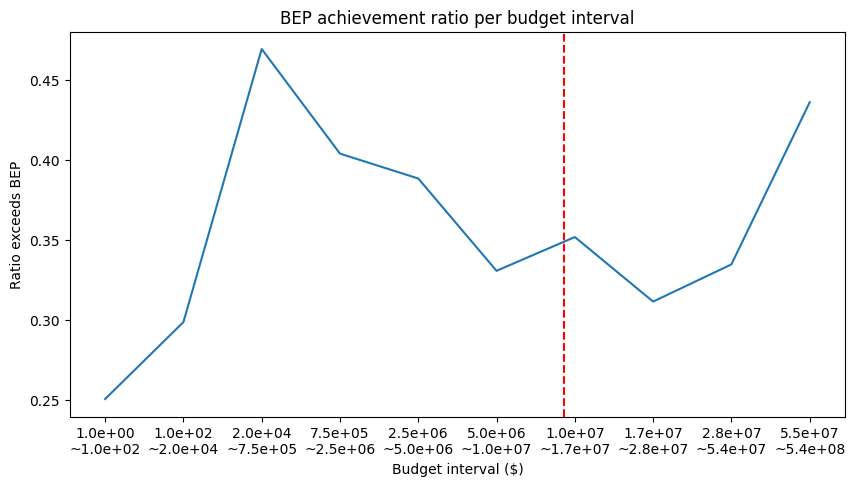

In [278]:
plt.figure(figsize=(10, 5))
plt.plot(label_str, bep_over_ratios)
plt.xlabel('Budget interval ($)')
plt.ylabel('Ratio exceeds BEP')
plt.title('BEP achievement ratio per budget interval')

plt.axvline(x=min_idx / bin_size, color='r', linestyle='--')
plt.show()

After some simple calculations, we have found an optimal point. If we set the boundary for 'Low-budget' and 'High-budget' movies at $9,500,000, we can minimize the gap in the percentage of successful movies between the two groups. Additionally, this division allows for a reasonably balanced distribution of sample sizes between the groups, with a ratio of 58:42.

Therefore, by dividing our data at this midpoint or using the optimal point we just obtained, we can expect to conduct our analysis with a reduced risk of encountering errors such as Simpson's Paradox. This approach should allow for a more nuanced understanding of the data in our study.

**Conclusion for quick overview of movie data:**
- The ratio of each movie's revenue to its budget appears to follow a normal distribution. This could be useful when employing statistical analysis techniques.
- The probability of a movie's success does not strictly increase or decrease with the scale of its budget, and there is no clear difference in average success rates between low-budget and high-budget movies.
- Overall, 63.8% of movies fail to break even. This could lead to a scarcity of 'successful' movie data points when analyzing actor data.
- Significant variations in various factors depending on the year of a movie's production necessitate caution against Simpson's Paradox when analyzing the data.
